In [302]:
# Import all required packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set()

In [303]:
# Read dataset csv file

data = pd.read_csv(r"C:\Users\Adi\Desktop\Data_Science\AutoGrid\load_temperature_data.csv", parse_dates=[['date', 'time']])

# Check the basic structure for all features

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45505 entries, 0 to 45504
Data columns (total 6 columns):
date_time             45505 non-null datetime64[ns]
Unnamed: 0            45505 non-null object
actual_kwh            37916 non-null float64
actual_temperature    12307 non-null float64
dow                   45505 non-null int64
month                 45505 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 2.1+ MB
None


### 1. Prepare the data

#### Data wrangling
1. Remove unwanted column(s)
2. Filter for desired date range. Exclude Nov 1, 2012 as kwh values are null
3. Sort dataset by datetime index
4. Convert dataset in dataframe with datetime as index
5. Rename columns for ease of access
6. Manually add first missing kwh value same as following value

In [304]:
data.drop(columns='Unnamed: 0', inplace=True)                                   # drop first column                            
data = data[(data.date_time >= '2012-11-02') & (data.date_time < '2013-12-02')] # filter dataset
data = data.sort_values(by=['date_time']).reset_index(drop=True)                # sort by datetime column

df = data.drop(['date_time'], axis=1) # convert dataset into dataframe with datetime index
df.index = data.date_time


df.rename(columns={'actual_kwh': 'kwh', 'actual_temperature': 'temp'}, inplace=True) # rename and fix columns
df.loc['2012-11-02 00:00:00', 'kwh'] = df.loc['2012-11-02 00:15:00', 'kwh']          # manual entry to first kwh value

### 2. Analyze the data

##### Daylight savings
There are 4 additional repeat periods with missing values for daylight savings time change in Nov 2013. Drop those null values. Also, there are missing timestamps when the clock is adjusted earlier in March 2013 from 1 am to 3 am i.e 4 missing 15 minute periods.

##### Temperature values
Temperature is captured every 1 hour as compared to kwh which is 15 minute duration. Fill in temperature values as linear line between two capture point. The idea is temperature will not fluctuate every 15 minutes and can be considered to change gradually within one hour. 

In [305]:
# Daylight saving adjustment
df.dropna(subset=['kwh'], inplace=True) # drop daylight savings missing values for actual_kwh

# Fill missing temperature values
df['temp'].interpolate(method='linear', inplace=True)

##### Validate periods

1. Total number of days in dataframe is 395 (index difference + 1)
2. Missing periods for values in March (daylight savings) is 4
3. Total available periods is 39716


Instances are captured every 15 minutes, this gives 96 periods in a day i.e. 4 periods per hour for 24 hours

In [306]:
print('Index difference: ', (max(df.index) - min(df.index)))

# Total 15 minute periods

days = 395
periods = days * 24 * 4
missing = 4 # Daylight savings March 2013
total_periods = periods - missing
print('\nTotal periods:' ,total_periods)

# Verify dataframe total rows
print('Length of dataframe:', len(df))

# Check df for missing values
df.isnull().any()

Index difference:  394 days 23:45:00

Total periods: 37916
Length of dataframe: 37916


kwh      False
temp     False
dow      False
month    False
dtype: bool

##### Validate data

1. Check for missing values - none
2. Check for outliers

Plot shows outliers kwh values around Nov 17, 2013. Further research shows kwh value dropped starting starting Nov 16th all the to 0 on Nov 17th. This could be either due error logs, system failure or ad-hoc facility shutdown. This date is not a national holiday. 

It will be a good idea to fix this by making values equal to last week as outliers can reduce the model accuracy if not sure of possible reasons.

Null values:
kwh      False
temp     False
dow      False
month    False
dtype: bool


Display instances when kwh is below 30


,kwh,temp,dow,month
date_time,,,,
2013-08-17 07:45:00,29.4,60.500,5,8
2013-08-17 08:00:00,28.5,61.000,5,8
2013-08-17 08:15:00,22.5,61.275,5,8
2013-08-17 08:30:00,6.3,61.550,5,8
2013-08-17 08:45:00,0.0,61.825,5,8
2013-08-17 09:00:00,0.0,62.100,5,8
2013-08-17 09:15:00,0.0,62.800,5,8
2013-08-17 09:30:00,0.0,63.500,5,8
2013-08-17 09:45:00,0.0,64.200,5,8


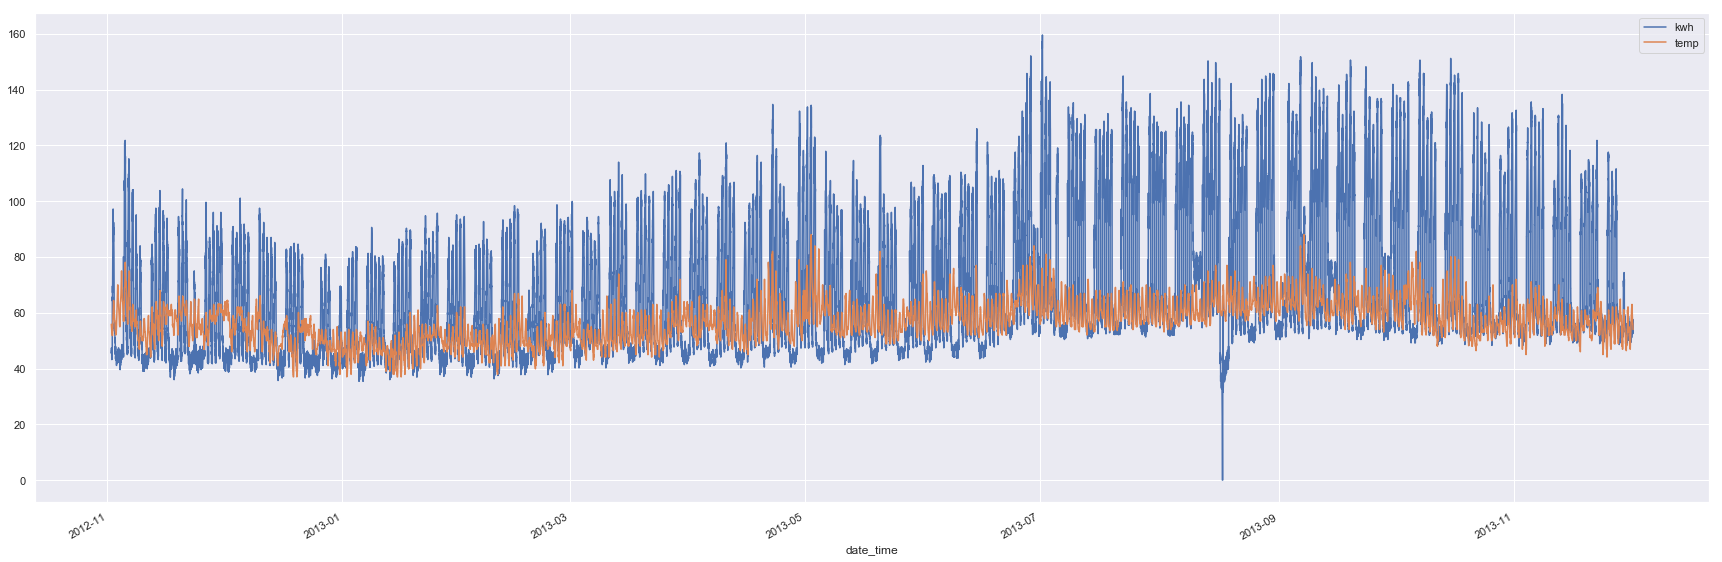

In [307]:
# check df for missing values
print('Null values:')
print( df.isnull().any())

# Plot kwh and temp values
df[['kwh', 'temp']].plot(figsize=(30,10))

# Outlier
print('\n\nDisplay instances when kwh is below 30')
(df[df.kwh < 30])

In [308]:
# Fix outliers
df.loc['2013-08-16':'2013-08-18', 'kwh'] = list(df.loc['2013-08-09':'2013-08-11', 'kwh']) # make values same as previous week

##### Trend analysis

Plot the few instances for dataframe columns. 

1. Weekly pattern - kwh

    There is a clear weekly pattern when viewed against DOW. Values peaks for 5 days and is stable for next 2 days. This signifies a 5 day week pattern. This could be load consumption at a business location. 


2. Daily pattern - temp

    It is cyclic with peaks and lows everyday which is a typical weather pattern. Temperature rises at similar time each day and is lowest at similar times each night.


3. Seasonality 

    Looking at the full plot above, there is also a slight upward trend in kwh which signifies increased usage over the year. This could be due to more head count at a work location or expanding business operations. Since we have data only for about a year, it is a good idea to ignore seasonality for the scope of this assignment.

    Also, the mean temperature shows trend as the change in mean temperature over the year. Again, I will ignore this for now to keep the scope limited to single trend for both kwh and temp.

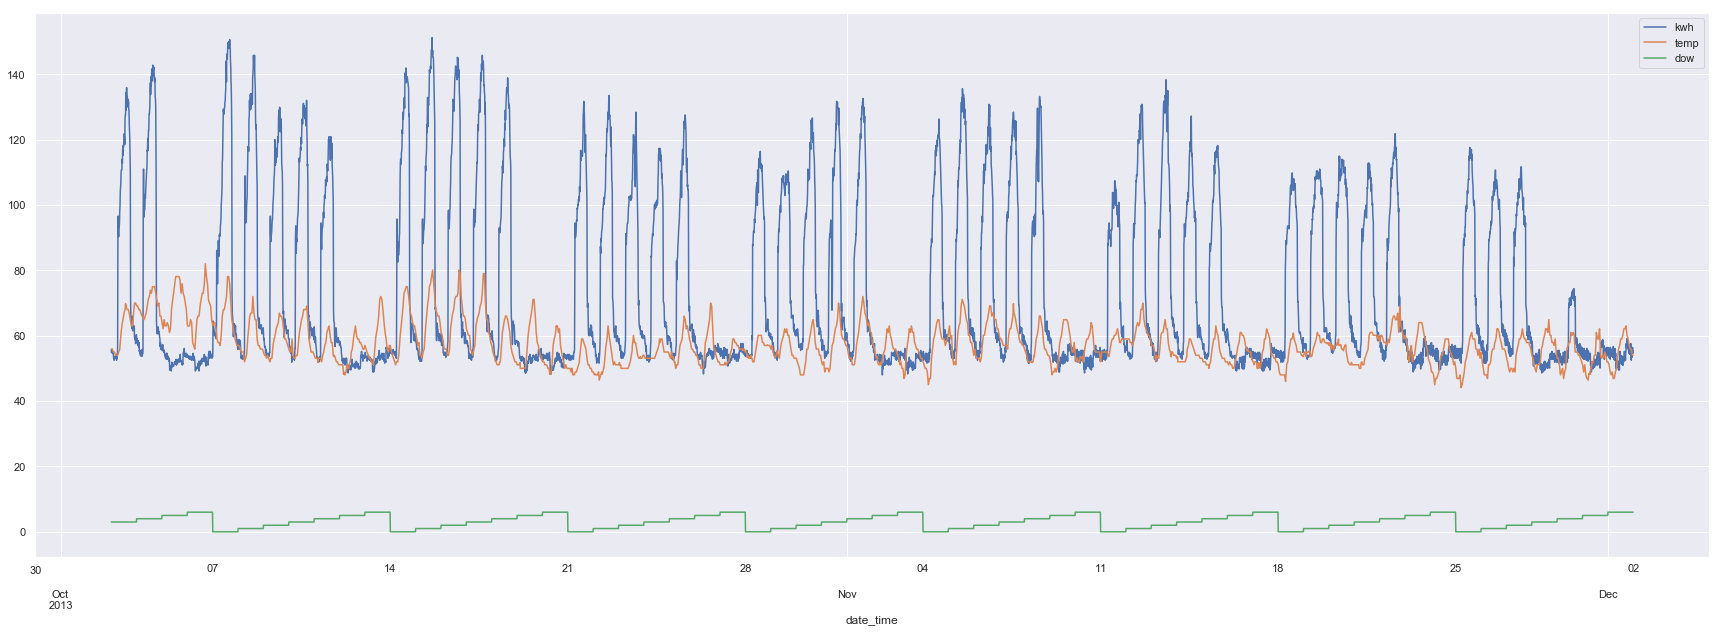

In [309]:
# Trend plot

df.loc['2013-10-03':'2013-12-01', 'kwh':'dow'].plot(figsize=(30,10))

##### Ad-hoc fixes

*Thanksgiving week*

Above plot shows outliers pattern for the last week of dataframe i.e. week of Nov 25, 2013. Further research confirms this is the Thanksgiving week. It is a good idea to drop the last week since it will not be a good candidate for test set. We are not capturing yearly patterns or holiday patterns in this analysis as data is only one year long.


In [310]:
# Remove last week from dataframe

thanksgiving_days = 7
holiday_period = thanksgiving_days * 96

test_days = 7
test_periods = test_days * 96

#print("\nTrain periods: ", train_periods)
print("\nTest periods: ", test_periods)

df = df[:-holiday_period] # restructure dataframe to reduce size by one week


Test periods:  672


### 3. Stationarity

It is evident there is cyclic trend for both series, kwh and temp. In order to model a time series we need to make transformation so series are stationary.

Ideally, stationary series will have no trend or seasonality with constant mean and variance. We will consider both series to be trend less and look for seasonality as a part of this analysis. 

##### tsplot

Plot both series along with histogram, ACF and PACF to look for patterns.

1. **kwh**
    
    Series plot show a pattern with 5 peaks followed by 2 stable days
    
    Histogram shows the values are not normally distributed
    
    ACF shows are strong auto-correlation after every 96 lags i.e. one day. This value is highest around ~700 lags which is 7X96 or one week - **strong weekly pattern**


2. **temp**
    
    Series plot show a pattern with 1 peak followed by 1 trough. It also shows a yearly trend where mean value is higher during summer months, but since we have data only for one year I will consider only daily pattern for the scope of this assignment.
    
    Histogram shows the values are not normally distributed
    
    ACF shows are strong auto-correlation after every lag which means temperature is close to what it was 15 minute prior. However, the values show strong cyclic pattern. ACF gradually goes down around 48 lags (12 hour gap) and comes back up at 96 lags (one day gap). This confirms **daily pattern**.

In [311]:
# Define tsplot function

def tsplot(y, title, lags=None, figsize=(20, 10)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

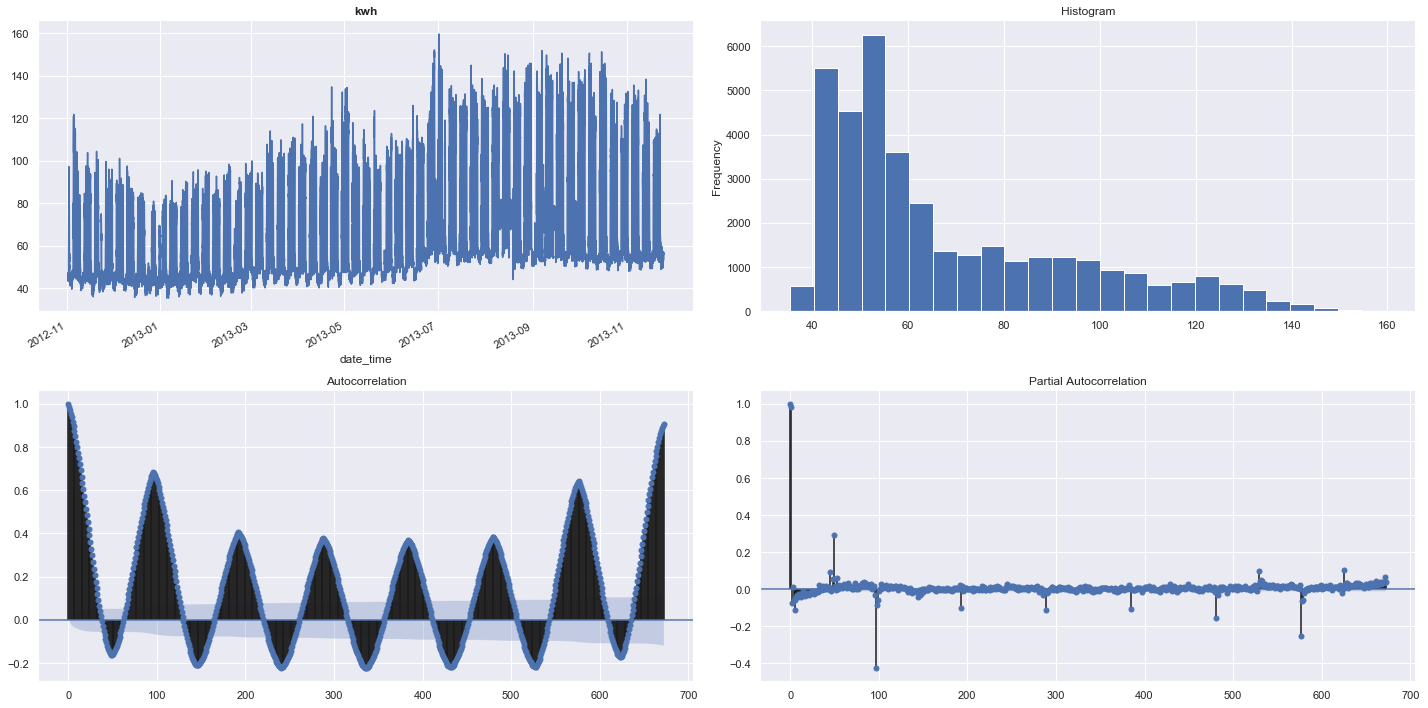

(<matplotlib.axes._subplots.AxesSubplot at 0x226901ac320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2268f67bf60>)

In [312]:
# tsplot kwh

lags_kwh = 7 * 96 # weekly lags
tsplot(df.loc[:, 'kwh'], title='kwh', lags=lags_kwh)

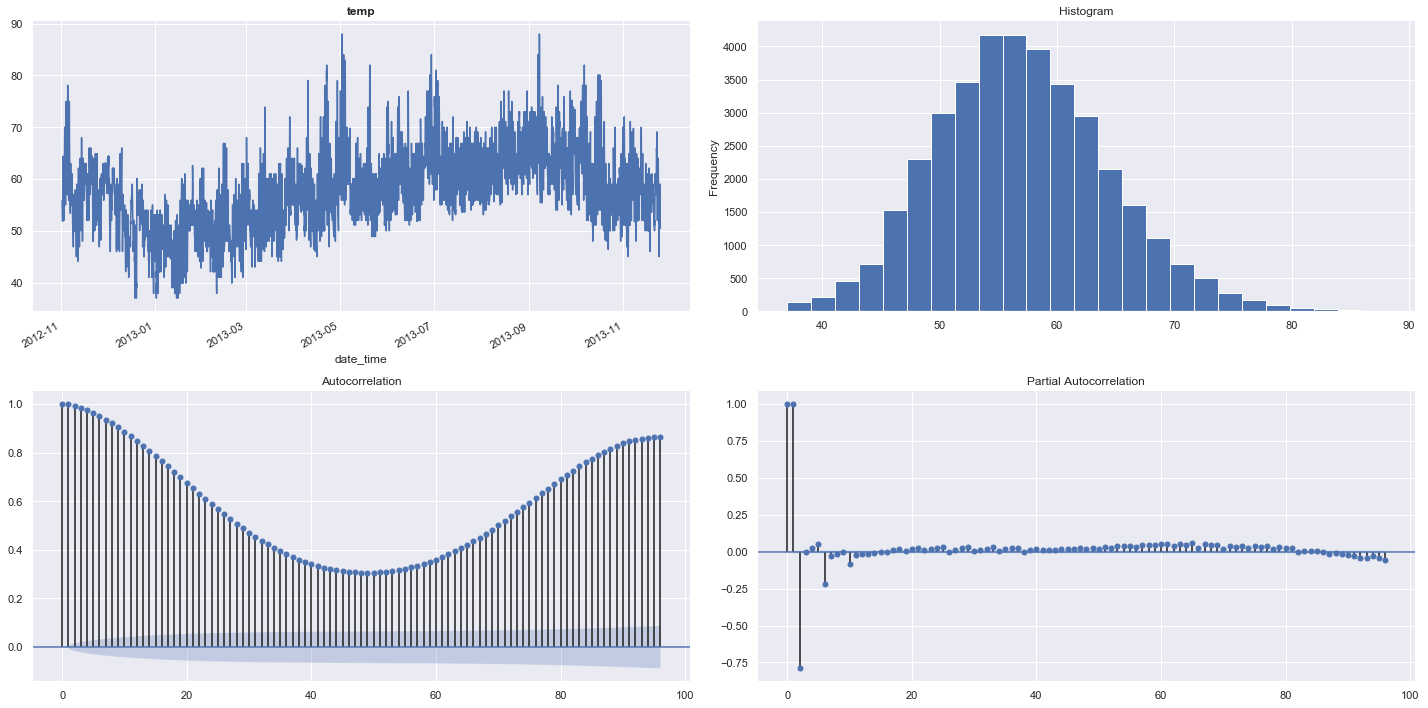

(<matplotlib.axes._subplots.AxesSubplot at 0x2269143be48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x226912836a0>)

In [313]:
# tsplot temp

lags_temp = 96 # daily lags
tsplot(df.loc[:, 'temp'], title='temp', lags=lags_temp)

##### Transformation

Now that we have identified the patterns in both series next step is to make them stationary for modeling.

**log differences** - find the difference in log of current value and lagged value. This way transformed series will capture the relative change between two values which should be constant. Hence producing a stationary series.

Once the series is transformed, drop null values those are in the initial rows before lagged instances kick in.


In [314]:
# Create copy of dataframe
transformed = df.copy(deep=True)

transformed['kwh'] = np.log(df.loc[:, 'kwh']).diff(lags_kwh)    # log transformation with weekly lag
transformed['temp'] = np.log(df.loc[:, 'temp']).diff(lags_temp) # log transformation with daily lag

transformed.dropna(how='any', inplace=True) # drop null values

##### Validation

After transformation check the tsplot to confirm if series are stationary.

Transformed series tsplot show are constant mean, normally distributed series. PACF is non significant for higher lags. There is still ACF for various lags, this could be due to other yearly or seasonal trends in the series which we are not capturing for this analysis


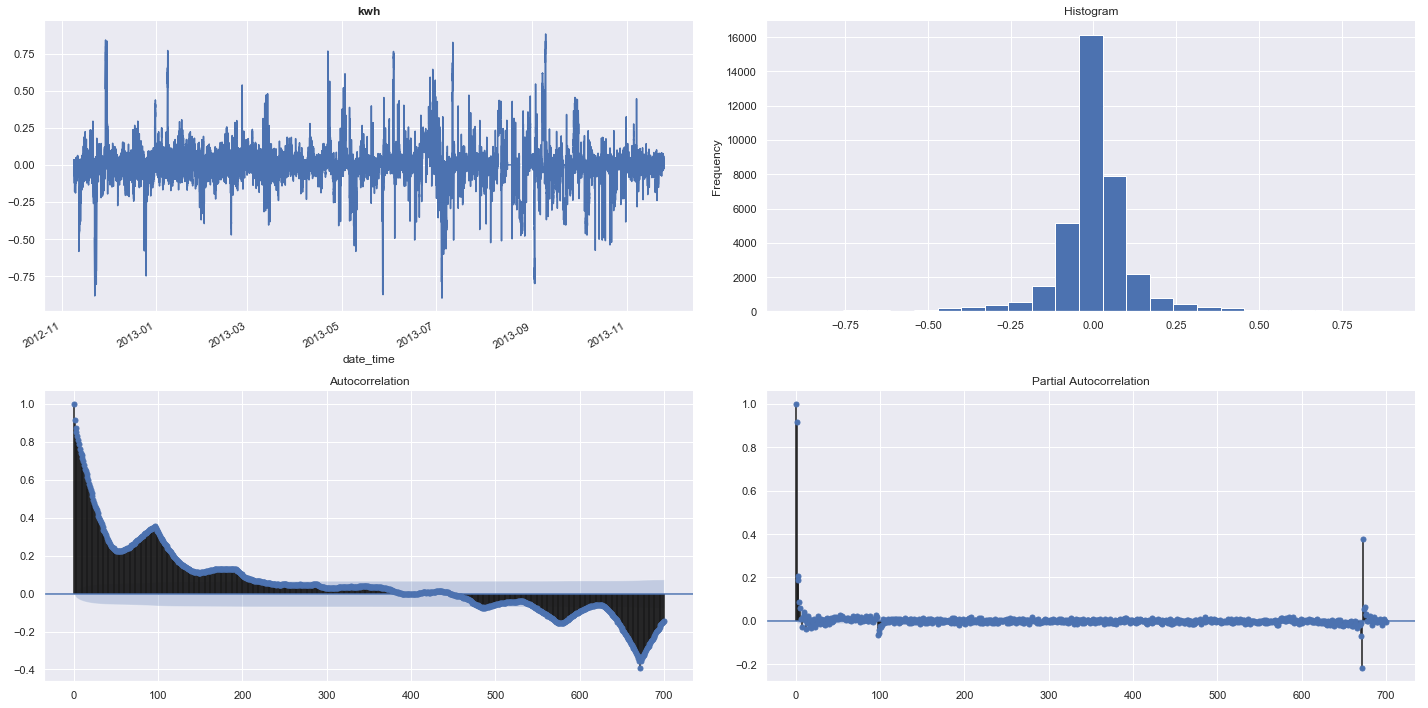

(<matplotlib.axes._subplots.AxesSubplot at 0x226901f1128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22691833b38>)

In [315]:
# tsplot for kwh

tsplot(transformed.loc[:, 'kwh'], title='kwh', lags=700)

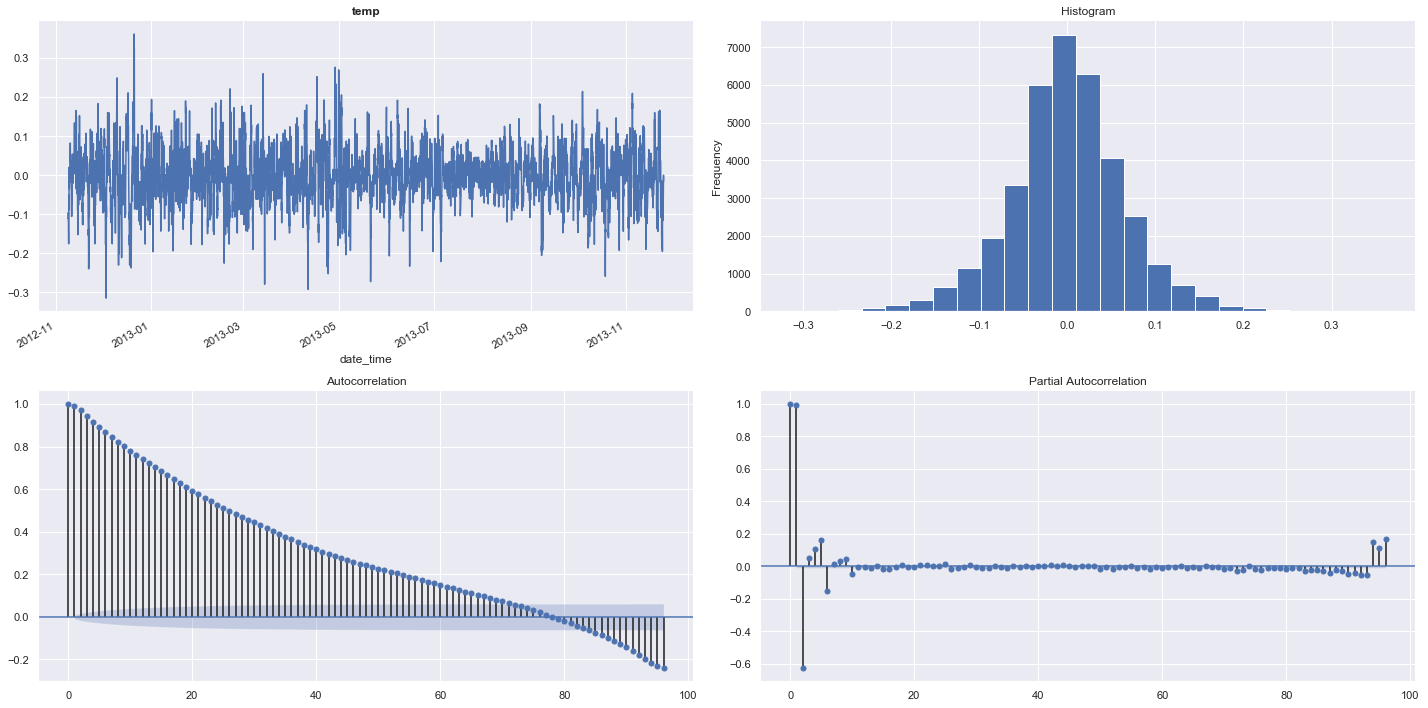

(<matplotlib.axes._subplots.AxesSubplot at 0x22691a057b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22691c4e898>)

In [316]:
# tsplot for temp

tsplot(transformed.loc[:, 'temp'], title='temp', lags=lags_temp)

### 4. VAR model

Use VAR model to multivariate time series forecasting. It is an extension of univariate autoregressive model and fairly easy to implement for the accuracy as compared to other complex algorithms.

1. Prepare training set - reduce transformed series by one week
2. Test set will be last week in series
3. Run the model for orders 1 through 5 and chose the one with minimum AIC


**Diagnostics**

Model diagnostic plot show residuals are centered around zero mean and do not show any pattern. Normal Q-Q plot shows residuals are normally distributed with outliers on either end. This could be due to yearly seasonality which was not captured in our analysis. 

In [317]:
# Filter out last week i.e. 7*96 periods from transformed series

train_df = transformed.iloc[:-test_periods, 0:2] # ending Nov 17th, 2013

# Last week of dataframe is hold out test set

test_df = df.iloc[-test_periods:, 0:2] # ending Nov 24th, 2013

In [318]:
# VAR model

AIC = np.inf
BIC = None
HQIC = None
best_model = None
Order = None

for i in range(5):
    i += 1
    model = sm.tsa.VARMAX(train_df, order=(i,0))
    model_result = model.fit(maxiter=1000, disp=False)

    if model_result.aic < AIC:
        Order = i
        AIC = model_result.aic
        BIC = model_result.bic
        HQIC = model_result.hqic
        best_model = model
            
print('Order = ', i)
print('AIC: ', model_result.aic)
print('BIC: ', model_result.bic)
print('HQIC: ', model_result.hqic)    

C:\Users\Adi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Adi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Adi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Adi\Anaconda3\lib\site-packages\sta

Order =  5
AIC:  -369014.83565947064
BIC:  -368802.62334510876
HQIC:  -368947.32172392623


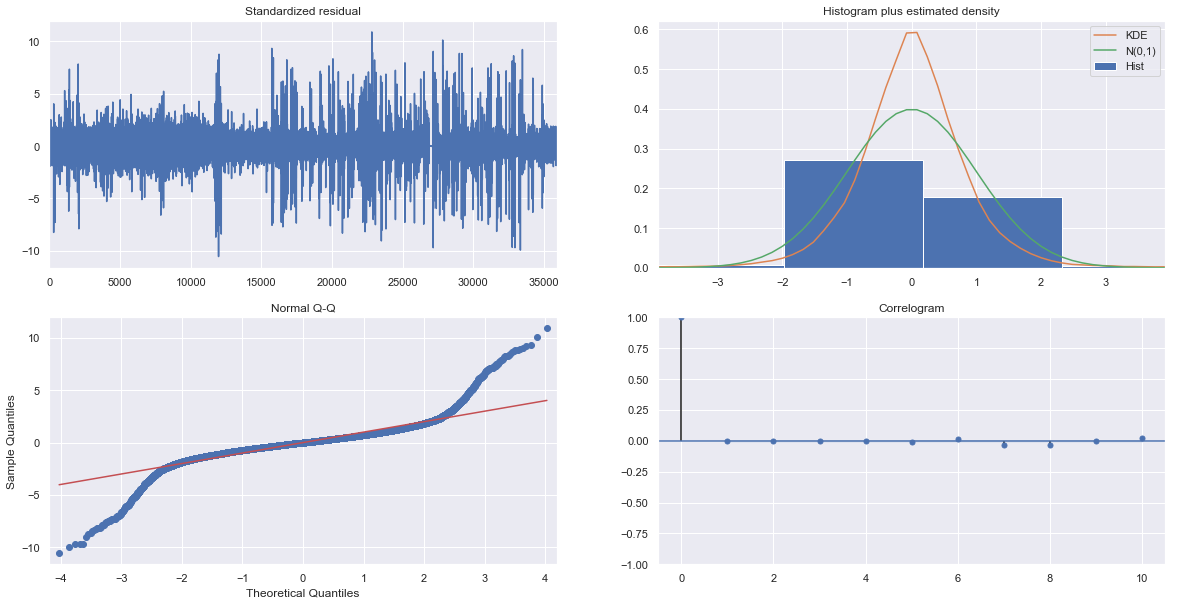

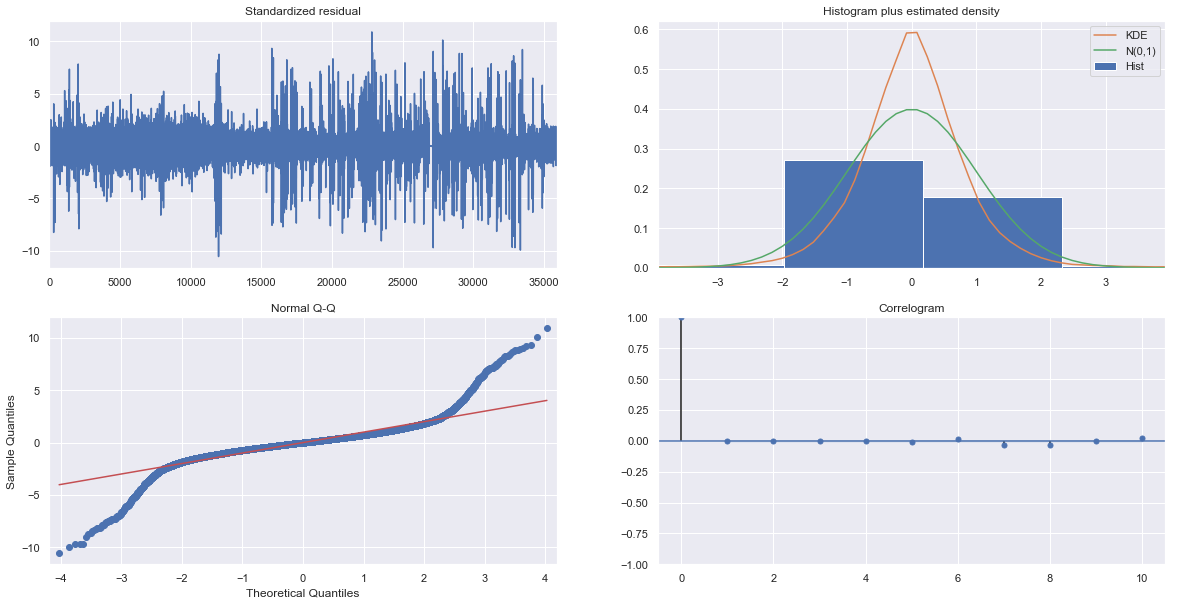

In [319]:
# Model diagnostics plots

model_result.plot_diagnostics(figsize=(20,10))

### 5. Prediction and forecast

Dataframe ends on Nov 24, 2013

Training set ends on Nov 17, 2013

Week of Nov 17, 2013 is hold out test set. This will be used for **out of sample error**

Week of Nov 11, 2013 is prediction set. This will be used for **in sample error**

##### De-transformation

Predicted and forecast values for training and test set respectively will need to be de-transformed from their log values to original values.

##### Plots

Predicted and forecast plots shows the model captures the time series pattern for kwh

In [320]:
# Forecast result for test set

z_forecast = model_result.forecast(steps=test_periods) # forecast for 7*96 periods
z_forecast.index = test_df.index                       # set index same as last week of dataset

# Predict for last week of training set i.e. week of Nov 11, 2013

z_prediction = model_result.predict(start=35228, end=35899, dynamic=False)

# Sice dataframe by week for in sample and out of sample

Nov_4_week = df.iloc[-test_periods*3:-test_periods*2, 0:2] # one week lag for forecasting in sample set
Nov_11_week = df.iloc[-test_periods*2:-test_periods, 0:2]  # last week of training data i.e. in sample set
Nov_18_week = df.iloc[-test_periods:, 0:2]                 # test data i.e. out of sample set

C:\Users\Adi\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Adi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [321]:
# Predict actual values from transformed series

prediction = np.exp(z_prediction['kwh'].values) * Nov_4_week['kwh'].values # de transform predicted value in training set
forecast = np.exp(z_forecast['kwh'].values) * Nov_11_week['kwh'].values    # de transform forecast values in test set

# Assign list values to week dataframes

Nov_11_week['prediction'] = prediction
Nov_18_week['forecast'] = forecast

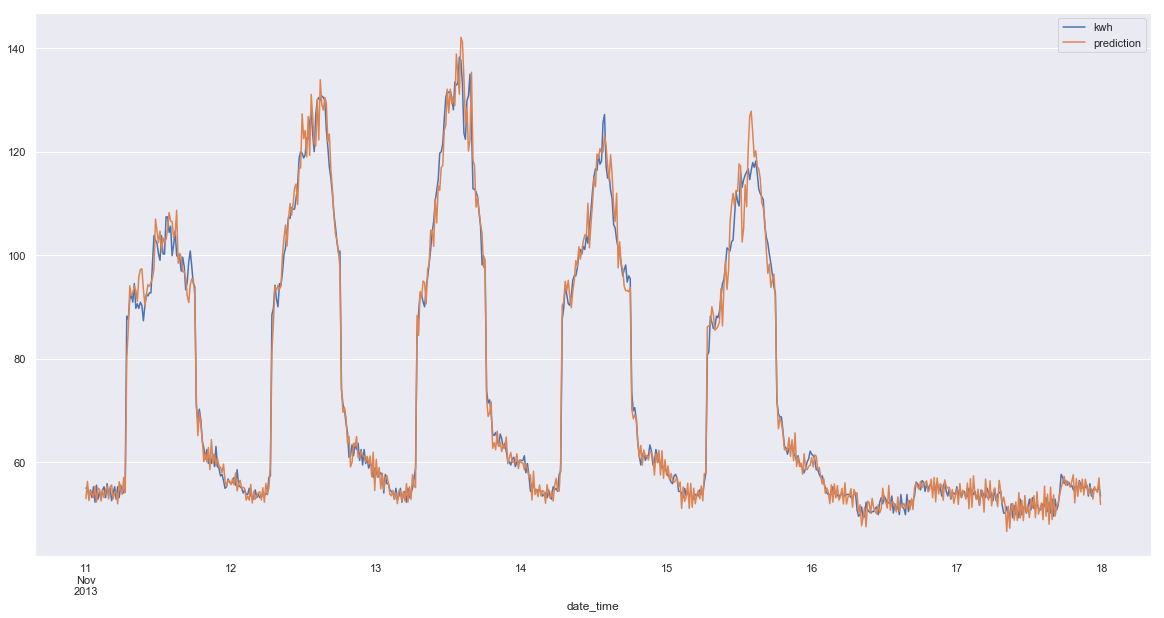

In [322]:
# Plot original kwh v/s predicted for last week of training dataset

Nov_11_week[['kwh', 'prediction']].plot(figsize=(20,10))

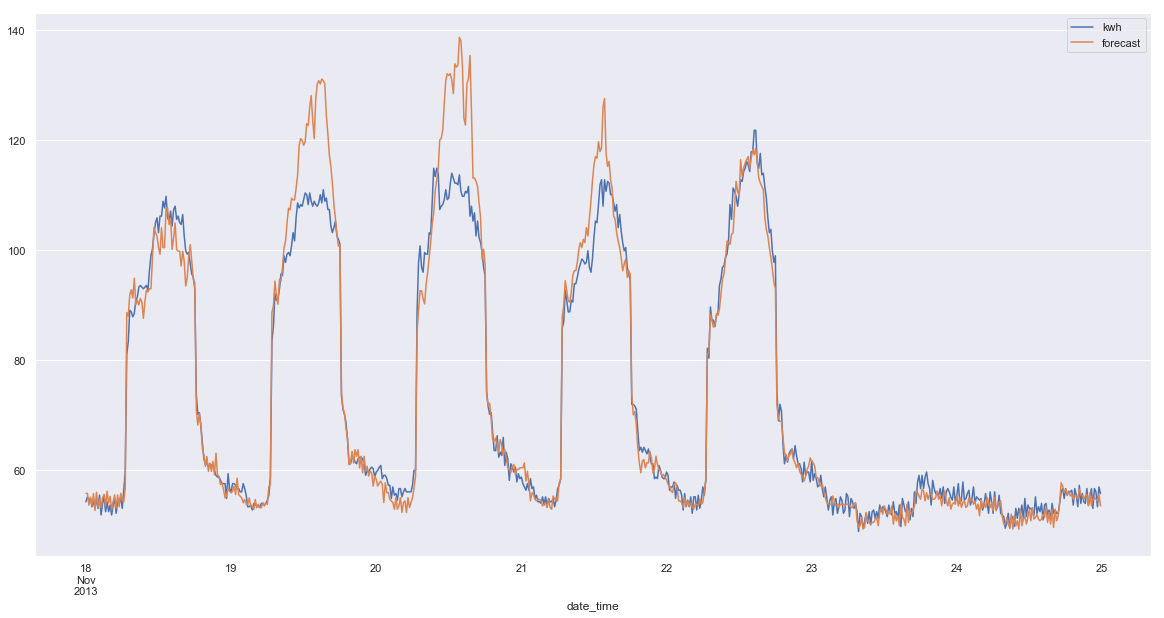

In [323]:
# Plot original kwh v/s forecasted for test dataset

Nov_18_week[['kwh', 'forecast']].plot(figsize=(20,10))

##### Mean Squared Error

MSE is used for accuracy validation on VAR model.

**In sample error** - this is calculated by comparing original kwh values with predicted values for the week of Nov 11, 2013

Predicted values are obtained from same data used for training the model, hence in sample. In sample error (also called re-substitution error) is optimistic because model is trained to the idiosyncrasy (noise) of dataset.

**Out of sample error** - is calculated by comparing original kwh values with forecast values for the week of Nov 18, 2013

Forecast values were obtained without using any original test data. Therefore, it is out of sample. Out of sample error (also called generalization error) is more than in sample because model will work with new noise pattern.

In [324]:
# In sample MSE

mse = mean_squared_error(Nov_11_week['kwh'], Nov_11_week['prediction'])
print('Nov 11 to Nov 17, 2013\n')
print('In sample MSE: %f' % mse)

Nov 11 to Nov 17, 2013

In sample MSE: 8.395371


In [325]:
# Out of sample MSE

mse = mean_squared_error(Nov_18_week['kwh'], Nov_18_week['forecast'])
print('Nov 18 to Nov 24, 2013\n')
print('Out of sample MSE: %f' % mse)

Nov 18 to Nov 24, 2013

Out of sample MSE: 30.336999


### END